# Integrating v2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import yaml

from astropy.io import fits
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import random

from scipy import integrate
from scipy.interpolate import interp2d, RectBivariateSpline
from matplotlib import pyplot as plt

In [3]:
from gravitational_wave_toy import GWToyV2 as gwt
from gravitational_wave_toy import GWToy as gwto
from gravitational_wave_toy import GWPlotter as gwp

/Users/jarred/Documents/Projects/gravitational_wave_toy/.venv/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


## Import a sample grb

In [4]:
filepath = "./GammaCatalogV2.0/run0639_ID000222.fits"
filepath = "./GammaCatalogV2.0/run0016_ID000340.fits"

In [18]:
grb = gwt.GRB(filepath)

In [17]:
with open("./gw_settings.yaml") as file:
    print("Settings file found!")
    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)
    
sensitivity = gwt.Sensitivities(parsed_yaml_file["grbsens_files"], parsed_yaml_file["energy_limits"])

Settings file found!


## Test the extrapolations

In [6]:
time_index = 50
energy_index = 10

time = grb.time[time_index]
energy = grb.energy[energy_index]
print(f"Spectrum at t={time}s:")
print(grb.get_spectrum(time))
print()
print(f"Value at {energy} GeV:")
print(grb.get_spectrum(time, energy))
print()
print(f"Lightcurve at energy {energy} GeV:")
print(grb.get_flux(energy))
print()
print(f"LC value at t={time}s:")
print(grb.get_flux(energy, time))

Spectrum at t=10000.0s:
[1.04168603e-06 6.29124848e-07 3.79959090e-07 2.29475771e-07
 1.38591578e-07 8.37021934e-08 5.05518250e-08 3.05307054e-08
 1.84389777e-08 1.11361953e-08 6.72568989e-09 4.06197119e-09
 2.45322193e-09 1.48162002e-09 8.94822382e-10 5.40426751e-10
 3.26389996e-10 1.97122791e-10 1.19052039e-10 7.19013071e-11
 4.34246624e-11 2.62261439e-11 1.58389466e-11 9.56505583e-12
 5.77498711e-12 3.48554021e-12 2.10269992e-12 1.26792985e-12
 7.64511320e-13 4.59613128e-13 2.74850017e-13 1.63707380e-13
 9.55582055e-14 5.63948409e-14 3.13733175e-14 1.75472036e-14
 8.79377525e-15 4.10965819e-15 1.70569349e-15 4.61341528e-16
 0.00000000e+00]

Value at 10.0 GeV:
6.725689885086982e-09

Lightcurve at energy 10.0 GeV:
[1.08445940e-13 1.70921199e-13 2.79319407e-13 4.33693028e-13
 6.82427056e-13 1.09708082e-12 1.72903451e-12 2.82555370e-12
 4.38715674e-12 6.90329556e-12 1.10978457e-11 1.74905587e-11
 2.85827211e-11 4.43795764e-11 6.98323196e-11 1.12263527e-10
 1.76930898e-10 2.89136934e-10 

In [7]:
grb.get_spectrum(time=10)

array([1.75889001e-07, 1.06227921e-07, 6.41562075e-08, 3.87470536e-08,
       2.34012299e-08, 1.41331407e-08, 8.53569096e-09, 5.15511886e-09,
       3.11342697e-09, 1.88034995e-09, 1.13563478e-09, 6.85865066e-10,
       4.14227267e-10, 2.50171990e-10, 1.51091030e-10, 9.12512207e-11,
       5.51110497e-11, 3.32842429e-11, 2.01019729e-11, 1.21405590e-11,
       7.33227395e-12, 4.42831680e-12, 2.67447586e-12, 1.61524603e-12,
       9.75525625e-13, 5.89167361e-13, 3.55826811e-13, 2.14901096e-13,
       1.29789176e-13, 7.83858963e-14, 4.73409029e-14, 2.85910632e-14,
       1.72668550e-14, 1.04267195e-14, 6.29426524e-15, 3.79546153e-15,
       2.27942414e-15, 1.35202096e-15, 7.72566494e-16, 3.73229175e-16,
       0.00000000e+00])

In [8]:
grb.get_flux(energy=10)

array([1.08445940e-13, 1.70921199e-13, 2.79319407e-13, 4.33693028e-13,
       6.82427056e-13, 1.09708082e-12, 1.72903451e-12, 2.82555370e-12,
       4.38715674e-12, 6.90329556e-12, 1.10978457e-11, 1.74905587e-11,
       2.85827211e-11, 4.43795764e-11, 6.98323196e-11, 1.12263527e-10,
       1.76930898e-10, 2.89136934e-10, 4.48934677e-10, 7.06409398e-10,
       1.13563478e-09, 1.78979661e-09, 2.92484982e-09, 4.54133095e-09,
       7.14589233e-09, 1.14878480e-08, 1.81052142e-08, 2.95871715e-08,
       4.59391169e-08, 7.22857105e-08, 1.16202895e-07, 1.83088607e-07,
       2.98447437e-07, 4.59325560e-07, 6.78836423e-07, 8.44071918e-07,
       7.65275302e-07, 5.92348363e-07, 4.37484010e-07, 3.17005432e-07,
       2.37204919e-07, 1.74175695e-07, 1.24076763e-07, 8.81175895e-08,
       6.23695622e-08, 4.47376526e-08, 3.14531814e-08, 2.17021139e-08,
       1.46783133e-08, 9.86055241e-09, 6.72568989e-09, 4.50088633e-09,
       2.96366649e-09, 1.94293129e-09, 1.26820102e-09, 8.15000739e-10,
      

## Test an integration

In [12]:
grb.get_integral_spectrum(10)

TypeError: get_integral_spectrum() missing 2 required positional arguments: 'min_energy' and 'max_energy'

In [155]:
grb.get_fluence(0, 3600*2)

TypeError: get_fluence() missing 2 required positional arguments: 'min_energy' and 'max_energy'

## Comparing numbers
for run0016_ID000340

In [15]:
t = grb.time[1]
grb.get_flux(t, grb.energy[0]) * (grb.energy[5]**(-grb.get_spectral_index(t)))

2.1556069489602007e-08

In [16]:
grb.get_flux(t, grb.energy[5])

1.7387561657620888e-08

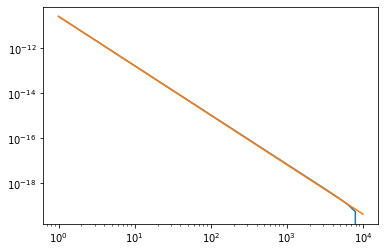

In [543]:
plt.loglog(grb.energy, [grb.get_flux(energy, t) for energy in grb.energy])
plt.loglog(grb.energy, [grb.power_law(energy, spectral_index=grb.get_spectral_index(t)) * grb.get_flux(grb.energy[0], t) for energy in grb.energy])
plt.show()

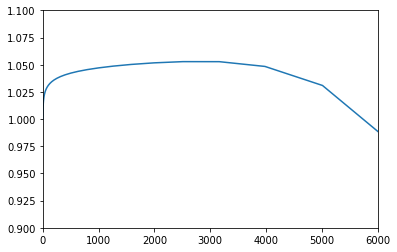

In [17]:
plt.plot(grb.energy, np.array([grb.get_flux(energy, t) for energy in grb.energy])/np.array([grb.power_law(energy, spectral_index=grb.get_spectral_index(t)) * grb.get_flux(grb.energy[0], t) for energy in grb.energy]))
plt.xlim(0, 6000)
plt.ylim(0.9, 1.1)
plt.show()

In [492]:
print(grb.get_flux(min(grb.energy), time=49602))
print(grb.get_spectral_index(time=49602))
print(grb.power_law(
                0.03,
                normalization=grb.get_flux(min(grb.energy), time=49602),
                spectral_index=grb.get_spectral_index(49602),
            ))

5.125264282972462e-08
-2.2772542503722426
2937.528544989053


In [522]:
grb.power_law(
                10,
                energy_0=min(grb.energy),
                normalization=grb.get_flux(min(grb.energy), time=49602),
                spectral_index=-2.6,
            )

1.28740818102992e-10

In [553]:
grb.get_flux(min(grb.energy), time=49602)

5.125264282972462e-08

In [562]:
grb.min_energy

0.03

In [21]:
t0 = 49602
t1 = 59602

# analytically solve inner energy integral
integrate.quad(lambda time: grb.get_flux(min(grb.energy), time=time) * 
               min(grb.energy)**(-grb.get_spectral_index(time)) * 
               1/(grb.get_spectral_index(time) + 1) * 
               (grb.max_energy**(grb.get_spectral_index(time)+1) - grb.min_energy**(grb.get_spectral_index(time)+1)), 
                t0, t1)[0]

0.02925206682488822

In [22]:
t0 = 49602
t1 = 59602

# analytically solve inner energy integral
integrate.quad(lambda time: grb.get_flux(min(grb.energy), time=time) * 
               min(grb.energy)**(-2.1) * 
               1/(-2.1 + 1) * 
               (grb.max_energy**(-2.1+1) - grb.min_energy**(-2.1+1)), 
                t0, t1)[0]

0.018268711167137

In [40]:
grb.get_spectrum(time=grb.time[0], energy=grb.energy[0])

1.6796287381150824e-11

In [42]:
grb.get_flux(energy=grb.energy[0], time=grb.time[0])

1.6796287381150824e-11

In [66]:
grb.min_energy, grb.max_energy

(0.03, 10)

In [36]:
gwt.observe_grb(filepath, sensitivity, start_time=71809, zeniths=[20], sites=["north"], precision=2)

NEW LOOP; t=71810.00, dt=1.00, previous_t=71810.00, previous_dt=-1.00 n=1.00
    AUTOSTEP; t=71810 dt=10000
    AUTOSTEP; resetting n
    Updating t: t: 81809.00, obs_t: 10000.00 start_time: 71809.00, n: 1.00, dt: 10000.00
    Normalization_flux: 0.00021137043187386144 Integral_spectrum: 2.1491821675912746e-06
    Fluence: 4.5708438144760254e-14 norm*int_spec = 4.5427356293936936e-10
    t=81809.00, dt=10000.00, avgflux=2.1491821675912745e-10, photon_flux=6.408230545297048e-12

Close solution, t=81809, avgflux=2.1491821675912745e-10, photon_flux=6.408230545297048e-12
NEW LOOP; t=81809.00, dt=1000.00, previous_t=71810.00, previous_dt=-1.00 n=0.00
    Updating t: t: 71810.00, obs_t: 1.00 start_time: 71810.00, n: 0.00, dt: 1000.00
    Normalization_flux: 2.4186811419535322e-08 Integral_spectrum: 2.463385204338326e-10
    Fluence: 5.958143339513933e-18 norm*int_spec = 5.958143339100457e-18
    t=71810.00, dt=1000.00, avgflux=2.463385204338326e-10, photon_flux=2.793960733894476e-09
    Upda

,zenith,site,min_energy,max_energy,seen,obs_time,start_time,end_time,run,id,ra,dec,eiso,z,angle
000340_0016,20,north,30,10000,True,39.69,71809,71848.69,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56


In [ ]:
grb.get_integral_spectrum(49603.00, grb.min_energy, grb.max_energy) 

In [443]:
integrate.quad(lambda x: gwto.spectrum(x), grb.min_energy, grb.max_energy)[0]

42.9580448189514

In [462]:
9.41972207974572e-10 / 1.258645808650498e-13 

7484.013385660429

### Testing v2 stuff with v1 code

In [396]:
v2n = gwp.open_gw_file("gw_toy_results_log_v2.pkl")
v1n = gwp.open_gw_file("gw_toy_results_log.pkl")

In [44]:
files = {
    "north": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z60_0.5h.txt",
    },
    "south": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z60_0.5h.txt",
    },
}

interpolations = gwto.get_fit_dict(files)
spectral_dict = gwto.get_integral_spectra(zeniths=[20, 40, 60])

bns = gwto.ParseBNS("BNS-GW.txt", sep="\t")

gwto.observe_grb(
    413,
    bns,
    interpolations,
    spectral_dict,
    tstart=49602,
    zenith=20,
    observatory="north",
    precision=2
)

NEW LOOP; t=49603.00, dt=1.00, previous_t=49603.00, previous_dt=-1.00 n=1.00
    AUTOSTEP; t=49603.00 dt=10000.00
    AUTOSTEP; resetting n
    Updating t: 59602.00, obs_t: 10000.00 start_time: 49602.00, n: 1.00, dt: 10000.00
    Normalization_flux: 0.0004375156402580362 Integral_spectrum: 0.021530023644846605
    t=59602.00, dt=10000.00, avgflux=9.41972207974572e-10, photon_flux=6.408230545297048e-12

Close solution, t=59602, avgflux=9.41972207974572e-10, photon_flux=6.408230545297048e-12
NEW LOOP; t=59602.00, dt=1000.00, previous_t=49603.00, previous_dt=-1.00 n=0.00
    Updating t: 49603.00, obs_t: 1.00 start_time: 49603.00, n: 0.00, dt: 1000.00
    Normalization_flux: 5.167963219339084e-08 Integral_spectrum: 0.021530023644846605
    t=49603.00, dt=1000.00, avgflux=1.1126637030806806e-09, photon_flux=2.793960733894476e-09
    Updating n: 0.10
NEW LOOP; t=49603.00, dt=1000.00, previous_t=49603.00, previous_dt=1000.00 n=0.10
    Updating t: 49703.00, obs_t: 101.00 start_time: 49603.00,

,run,id,ra,dec,eiso,z,angle,observatory,zenith,seen,tend,obstime,tstart
413,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,north,20,True,49606.04,4.04,49602


In [400]:
v2n[v2n.run == "0016"][:10]

,run,id,ra,dec,eiso,z,angle,zenith,observatory,seen,tend,obstime,tstart
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,86421.69,21.69,86400
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,71821.01,12.01,71809
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,59687.86,6.86,59681
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,49606.04,4.04,49602
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,41227.25,2.25,41225
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,34264.26,1.26,34263
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,28478.00,1.00,28477
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,23669.00,1.00,23668
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,19672.00,1.00,19671
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,16350.00,1.00,16349


### Testing the v1 code.  [it works]

In [399]:
files = {
    "north": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z60_0.5h.txt",
    },
    "south": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z60_0.5h.txt",
    },
}

interpolations = gwto.get_fit_dict(files)
spectral_dict = gwto.get_integral_spectra(zeniths=[20, 40, 60])

bns = gwto.ParseBNS("BNS-GW.txt", sep="\t")

gwto.observe_grb(
    413,
    bns,
    interpolations,
    spectral_dict,
    tstart=49602,
    zenith=20,
    observatory="north",
    precision=2
)

,run,id,ra,dec,eiso,z,angle,observatory,zenith,seen,tend,obstime,tstart
413,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,north,20,True,49673.99,71.99,49602


In [398]:
v1n[v1n.run == "0016"][0:10]

,run,id,ra,dec,eiso,z,angle,zenith,observatory,seen,tend,obstime,tstart
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,86624.34,224.34,86400
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,71960.77,151.77,71809
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,59784.83,103.83,59681
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,49673.99,71.99,49602
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,41273.54,48.54,41225
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,34295.67,32.67,34263
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,28499.21,22.21,28477
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,23683.27,15.27,23668
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,19681.64,10.64,19671
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,16356.27,7.27,16349
